In [2]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import plotting # source functions created for plotting

# Hide code:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# lifetimes packages:
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.utils import calibration_and_holdout_data
from lifetimes import BetaGeoFitter
from lifetimes import BetaGeoBetaBinomFitter

import hide_code
# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

ModuleNotFoundError: No module named 'plotting'

# Consumer Lifetime Value Modeling in Python
## A Tutorial Using `Lifetimes` (Python package equivalent to `BYTD` in R)
by Eden Huang, [in4mation insights](https://in4ins.com)

## Table of Contents

### [Introduction](#introduction)

## Section I. Model specification

### 1.1 [Assumptions of BG/NBD](#assumptions)

### 1.2 [Model Development](#model-development)


## Section II. Data preparation and cohort analysis  

### 2.1 [Data Preparation](#data-preparation)

### 2.2 [Cohort Analysis](#cohort-analysis)


## Section III. Implementation with `Lifetimes` 

### 3.1 [Model Implementation](#model-implementation)

### 3.2 [Predictive Results for All Cohorts](#predictive-results)

### 3.3 [Modeling Selected Cohorts](#predictive-results)


### [Further Reading](#further-reading)


<a id="introduction"></a>
## Introduction

**Section I** starts with the model assumptions of BG/NBD (Beta Geometric Negative Binomial Distribution) described in the paper [Counting Your Customers” the Easy Way: An Alternative to the Pareto/NBD Model](http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf) by Fader et al. in 2005. Prior to the implemenation with existing packages, we summarized the modeling section of the paper on model derivations. We used the example dataset provided in the paper to interpret some model results. 

**Section II** describes the data preparation process of BG/NBD model in the context of Altria Marlboro coupon analytics. This section proceeds with an exploratory analysis on different cohorts. The implementation of the BG/NBD consumer lifetime value model relies on the Python library called [Lifetimes](https://github.com/CamDavidsonPilon/lifetimes) by [Cam-Davidson Pilon](https://github.com/CamDavidsonPilon). 

**Section III** explains the model implementation step-by-step, and shows some preliminary results on individual consumers. This section starts with modeling on all cohorts. The modeling process is then replicated on selected cohort (April 2017 in California).  


<a id="assumption"></a>

# Section I. Model specification

**Section I** starts with the model assumptions of BG/NBD (Beta Geometric Negative Binomial Distribution) described in the paper [Counting Your Customers” the Easy Way: An Alternative to the Pareto/NBD Model](http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf) by Fader et al. in 2005. Prior to the implemenation with existing packages, we summarized the modeling section of the paper on model derivations. 

Note that in **Section I**, "*transactions*" refer to hypothetical purchase and all graphs are only for illustrative purpose. We also used optimization results from an example provided in Hardie's paper to interpret the model. **Section II** and **Section III** will apply the modeling setting to Marlboro data. 

### 1.1. Assumptions

The primary interest of the study is to predict the patterns of future *transactions* (e.g. Marlboro coupon redemptions) of consumers, which can then serve as an input into "lifetime value" calculations. Among the models that provide such capabilities, the beta-geometric/NBD (BG/NBD) framework proposed by Hardie and Fader (2005) is highly regarded. It is easy to implement and requires simple data input (transaction log of consumers). 

Given the model input as *<a href="https://en.wikipedia.org/wiki/RFM_(customer_value)">recency-frequency matrix</a>* format (see **Section 1.2.1** for details), BG/NBD generates four model outputs of BG/NBD $r$, $α$, $a$ and $b$ characterized by the **five assumptions** as follows:


#### **Assumption 1: While active, transactions made by a consumer in time period $t$ is Poisson distributed with mean $λt$**

Poisson distribution expresses the probability of a given number of transactions occurring in a fixed interval of time $t$ when these events occur with a known constant rate $λ$ and independently of the time since the last event. Intuitively, we would expect $λt$ numer of transactions throughout the period $t$. 
 
**Figure 1.1** shows the probability distribution related to the number of transactions for one individual consumer with $λ$ = 2 (e.g. two transactions per week on average). Further improvement to the generating process can impose additional constraints on the distribution. For example, in the case of Marlboro coupon redemption, we can set an upper bound on the number of transactions allowed each week.

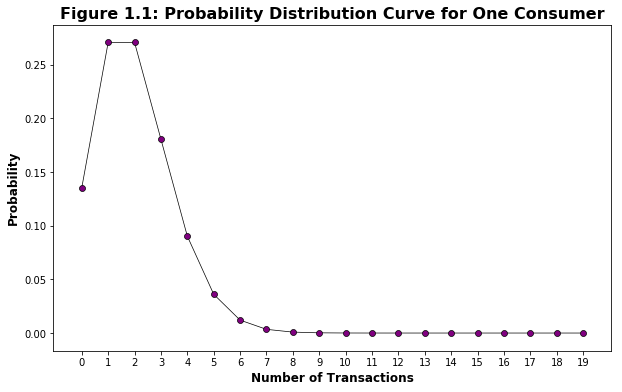

In [3]:
from scipy.stats import poisson

probability_arr = []
distribution = poisson(2)
for transactions in range(0,20):
     probability_arr.append(distribution.pmf(transactions))

plt.figure(figsize=(10,6))
plt.ylabel('Probability', fontsize=12, fontweight='bold')
plt.xlabel('Number of Transactions', fontsize=12, fontweight='bold')
plt.xticks(range(0, 20))
plt.title('Figure 1.1: Probability Distribution Curve for One Consumer', fontsize=16, fontweight='bold')
plt.plot(probability_arr, color='black', linewidth=0.7, zorder=1)
plt.scatter(range(0, 20), probability_arr, color='purple', edgecolor='black', linewidth=0.7, zorder=2)
plt.show()

#### **Assumption 2: Differences in transaction rate $λ$ between consumers follows a Gamma distribution with shape $r$ and scale $α$**

The Gamma distribution is often used to model time to failure, and arises naturally when the time between occurences are Poisson distributed. In particular, $r$ and $α$ are the two hyperparameters of Gamma distribution: $r$ controls the *shape* and *skewness* of distribution, while larger $α$ leads to wider *spread* of the distribution.
 
For example, **Figure 1.2** shows the probability distributions related to number of transactions for 100 consumers with $r$ = 9.0 and $α$ = 0.5:

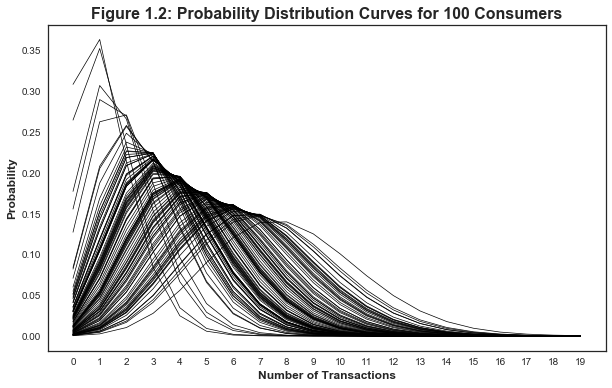

In [47]:
plt.figure(figsize=(10,6))

for customer in range(0, 100):
    distribution = poisson(np.random.gamma(shape=9, scale=0.5))
    probability_arr = []
    for transactions in range(0,20):
        probability_arr.append(distribution.pmf(transactions))
    plt.plot(probability_arr, color='black', linewidth=0.7, zorder=1)

plt.ylabel('Probability', fontsize=12, fontweight='bold')
plt.xlabel('Number of Transactions', fontsize=12, fontweight='bold')
plt.xticks(range(0, 20))
plt.title('Figure 1.2: Probability Distribution Curves for 100 Consumers', fontsize=16, fontweight='bold')
plt.show()

#### **Assumption 3: Each consumer becomes inactive after each transaction with probability $p$**

#### **Assumption 4: Differences in $p$ follows a beta distribution with shape parameters $a$ and $b$**

These two assumptions combined characterize the dropout process. The model assumes a random dropoff with probability $p$ that is Beta distributed with two hyperparameters $a$ = 1.0 and $b$ = 2.5 to each of our 100 consumers after each transaction. Both $a$ and $b$ are shape parameters that together control the shape of distribution.

Compared to **Figure 1.2**, we can see that this transformation moves the distribution to the left. The intuition is that after each transaction, the consumer can potentially drop out with certain probability. Such modified assumption leads to an increased likelihood of fewer transactions.

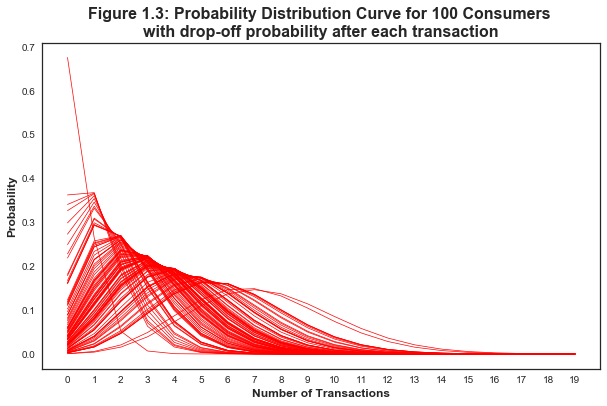

In [46]:
plt.figure(figsize=(10,6))

for customer in range(0, 100):
    distribution = poisson(np.random.gamma(shape=9, scale=0.5))
    probability_arr = []
    beta = np.random.beta(a=1.0, b=2.5)
    cumulative_beta = 0
    for transactions in range(0,20):
        proba = distribution.pmf(transactions)
        cumulative_beta = beta + cumulative_beta - (beta * cumulative_beta)
        inactive_probability = 1 - cumulative_beta
        proba *= inactive_probability
        probability_arr.append(proba)
    probability_arr = np.array(probability_arr)
    probability_arr /= probability_arr.sum()
    plt.plot(probability_arr, color='red', linewidth=0.7, zorder=1)

plt.ylabel('Probability', fontsize=12, fontweight='bold')
plt.xlabel('Number of Transactions', fontsize=12, fontweight='bold')
plt.xticks(range(0, 20))
plt.title('Figure 1.3: Probability Distribution Curve for 100 Consumers \nwith drop-off probability after each transaction', 
          fontsize=16, fontweight='bold')
plt.show()

#### Assumption 5: Transaction rate and dropout probability vary independently between consumers

This assumption captures the "heterogeneity" in both transaction occurences and dropout processes for consumers.

<a id='model-development'></a>

## 1.2. Model Development

### 1.2.1. Model data input

The input of the BG/NBD model requires a <a href="https://en.wikipedia.org/wiki/RFM_(customer_value)">recency-frequency matrix</a> format where:

- $x$ is the number of repeat purchases from this consumer since the first purchase (*frequency*)
- $t_x$ is the date of the most recent purchase in weeks since the consumer’s first purchase (*recency*)
- $T$ is the time to be considered in weeks since the consumer’s first purchase

For example, the sample data in an example provided by Hardie and Fader has the following form:

In [112]:
df = pd.read_excel('bgnbd.xls', sheet_name='Raw Data').set_index('ID')
df.head()

,x,t_x,T
ID,,,
1,2,30.428571,38.857143
2,1,1.714286,38.857143
3,0,0.000000,38.857143
4,0,0.000000,38.857143
5,0,0.000000,38.857143


### 1.2.2. Optimizing the likelihood function parameters

Given the above assumptions, the likelihood a consumer makes $x$ purchases in a given time period $T$ is:

$L(\lambda, p | X=x, T) = (1-p)^x \lambda^x e^{-\lambda T} + \delta_{x>0}p(1-p)^{x-1}\lambda^x e^{-\lambda t_x}$

<br>
<br>
However, this depends on knowing the variables $λ$ and $p$, which are both unobserved quantities. We can, instead, write the likelihood function of a randomly-chosen individual with purchase history $X = x, t_x, T$ as:

$L(r, \alpha, a, b|X=x, t_x, T) = A_1 A_2 (A_3 + \delta_{x>0} A_4)$

$\text{Where}$

- $A_1 = \dfrac{\Gamma(r+x)\alpha^r}{\Gamma(r)}$

- $A_2 = \dfrac{\Gamma(a+b)\Gamma(b+x)}{\Gamma(b) + \Gamma(a+b+x)}$

- $A_3 = \dfrac{1}{\alpha + T}^{r+x}$

- $A_4 = \bigg( \dfrac{a}{b+x-1}\bigg)\bigg(\dfrac{1}{\alpha + t_x}\bigg)^{r+x}$


<br>
<br>
The **log-likelihood function** is specified as follows:

- $\ln[L(r, \alpha, a, b|X=x, t_x, T) = \ln(A_1) \ln(A_2) \ln(e^{\ln(A_3)} + \delta_{x>0} e^{\ln(A_4)})]$

$\text{Where}$

- $\ln(A_1) = \ln[\Gamma(r+x)] – \ln[\Gamma(r)] + r\ln(\alpha)$

- $\ln(A_2) = \ln[\Gamma(a+b)] + \ln[\Gamma(b+x)] – \ln[\Gamma(b)] –  \ln[\Gamma(a+b+x)]$

- $\ln(A_3) = -(r+x) \ln(\alpha + T)$

- $\ln(A_4) = \begin{cases} \ln(a) – \ln(b+x-1) – (r+x)\ln(\alpha + t_x) & \text{if}\ x>0 \\ 0 & \text{otherwise} \end{cases}$

<br>
<br>
We can then optimize the paramaters of the likelihood function by *minimizing the negative log likelihood cost function*. The method used by Hardie and Fader is the *Nelder-Mead Simplex algorithm*, which is a heuristic, non-gradient search method. 

The opimization gives closed form solutions to four model outputs ($r$, $α$, $a$ and $b$). 

### 1.2.3. Expected transaction forecasting for the *cohort* of consumers

After deriving the parameters $r$, $α$, $a$ and $b$, we can use these to compute our repeat transaction forecast for our *cohort* of consumers across time period of length t using the following formula for any given individual:

$E(X(t)|r, \alpha, a, b) = \dfrac{a+b-1}{a-1}\bigg[ 1 – \bigg(\dfrac{\alpha}{\alpha + t}\bigg)^r {}_{2}F_{1}(r, b; a+b-1;\dfrac{t}{\alpha+t}) \bigg]$

$\text{Where}$ $2F1$ is the Gaussian hypergeometric function with the form:

${}_{2}F_{1}(a, b; c; z) = \sum\limits_{j=0}^{\infty} u_j$ 

$\text{where  } u_j = \dfrac{(a)_j(b)_j}{(c)_j)}\dfrac{z^j}{j!}$

<br>

Then we can derive series of t to get the *expected transaction to time t* by sustituting the values above for $a$, $b$, $c$ and $z$ values of the hypergeometric function.

<br>

For example, given four optimized parameters from an *example* provided in Hardie's paper:
- r = 0.242594123569
- alpha = 4.41358813135
- a = 0.792935471652
- b = 2.42595536972

we can calculate the expected number of transactions from an individual across a period of one year (52 weeks). The result below shows that we would expect 1.44 transactions for **any given individual** across the next year.

In [114]:
from scipy.special import hyp2f1

r = 0.242594123569
alpha = 4.41358813135
a = 0.792935471652
b = 2.42595536972

def expected_trs_to_time_t(t):
    hyp2f1_a = r
    hyp2f1_b = b
    hyp2f1_c = a + b - 1
    hyp2f1_z = t / (alpha + t)
    hyp_term = hyp2f1(hyp2f1_a, hyp2f1_b, hyp2f1_c, hyp2f1_z)
    
    return ((a + b - 1) / (a - 1)) * (1-(((alpha / (alpha+t)) ** r) * hyp_term))

res = round(expected_trs_to_time_t(52),2) # 1.44

Now will calculate the cumulative repeat transactions for 78 weeks from our **cohort** of consumers. Note that to calculate cumulative repeat transactions for a forecast across our cohort, we can’t just scale up to number of consumers, we need to take into account the fact that each consumer had a different time of first purchase. The formula of cohort-level forecasting is as follows:



$\text{Total repeat transactions to } t = \sum\limits_{s=0}^{S} \delta_{(t>s)} n_s E[X(t-s)]$

where

- $n_s$ is the number of people that had their first purchase on day $s$ 

- $S$ is the total possible number of start dates

- $\delta_{(t>s)} = \begin{cases} 1 & \text{if}\ t>s \\ 0 & \text{otherwise} \end{cases}$

In [9]:
# Period of consideration is 39 weeks. 
# T indicates the length of time since first transaction
n_s = (39 - df['T']).value_counts().sort_index()

forecast_range = np.arange(0, 78, 1/7.0)

def cumulative_repeat_transactions_to_t(t):
    expected_transactions_per_customer = (t - n_s.index).map(lambda x: expected_trs_to_time_t(x) if x > 0 else 0)
    expected_transactions_all_customers = (expected_transactions_per_customer * n_s).values
    return expected_transactions_all_customers.sum()

cum_rpt_trs = pd.Series(map(cumulative_repeat_transactions_to_t, forecast_range), index=forecast_range)
print(cum_rpt_trs.tail(5))

77.285714    4135.243956
77.428571    4140.326675
77.571429    4145.403724
77.714286    4150.475118
77.857143    4155.540873
dtype: float64

From the above results:
- 18 people made their first transaction on day 1 (1/7 weeks), 22 on day 2 (2/7 weeks), 17 on day 3 (1/7 weeks) etc
- Across the next 78 weeks we would expect to make around 4156 repeat transactions from our cohort of consumers.

### 1.2.4. Expected transaction forecasting for individual consumers

To calculate the expected number of transactions from a single consumer going forward in time period $t$, we first need to derive the conditional expectation for that consumer as follows:

$E(Y(t)|X=x, t_x, T, r, \alpha, a, b) = \dfrac{a + b + x – 1}{a-1} \times \dfrac{\bigg[1 – \bigg(\dfrac{\alpha + T}{\alpha + T + t}\bigg)^{r+x}{}_{2}F_{1}(r+x, b+x; a+b+x-1; \dfrac{t}{\alpha+T+t})\bigg]}{1 + \delta_{(x>0)}\dfrac{a}{b+x-1}\bigg(\dfrac{\alpha + T}{\alpha + t_x}\bigg)^{r+x}}$

In [108]:
def calculate_conditional_expectation(t, x, t_x, T):
    first_term = (a + b + x - 1) / (a-1)
    hyp2f1_a = r + x
    hyp2f1_b = b + x
    hyp2f1_c = a + b + x - 1
    hyp2f1_z = t / (alpha + T + t)
    hyp_term = hyp2f1(hyp2f1_a, hyp2f1_b, hyp2f1_c, hyp2f1_z)
    second_term = (1 - ((alpha + T) / (alpha + T + t)) ** (r + x) * hyp_term)
    delta = 1 if x > 0 else 0
    denominator = 1 + delta * (a / (b + x - 1)) * ((alpha + T) / (alpha + t_x)) ** (r+x)
    return first_term * second_term / denominator

res = round(calculate_conditional_expectation(39, 2, 30.43, 38.86), 2) # 1.23

Therefore, in the example data, we would expect a consumer with:

- $x$ = 2
- $t_x$ = 30.43
- $T$ = 38.86

to make approximately 1.23 transactions over the next 39 weeks, given that they’re drawn from the same cohort as the others used to calculate model parameters.

<a id='data-preparation'></a>

# Section II. Data preparation and cohort analysis 

**Section II** describes the data preparation process of BG/NBD model in the context of Altria Marlboro coupon analytics. This section proceeds with an exploratory analysis on different cohorts. The implementation of the BG/NBD consumer lifetime value model relies on the Python library called [Lifetimes](https://github.com/CamDavidsonPilon/lifetimes) by [Cam-Davidson Pilon](https://github.com/CamDavidsonPilon). 

## 2.1 Data Preparation

The previous section briefly explains the model development and interprets the model results with example data. Now we move on to the actual Marlboro mobile coupon redemption data (DMS_MC_REDEMPTIONS). The preprocessed redemption data is in a form of transaction log (in days), recording all coupon redemptions for each individual MC user. 

Since there weren't many mobile coupon given out before 2016, we define calibration period (or model training period) as **2016-01-03** (Sunday) to **2018-06-30** (Saturday), in total of 130 weeks. The holdout period (to evaluate a model's out-of-sample performance) is defined as **2018-07-01** (Sunday) to **2018-07-29** (Saturday), 4 weeks in total. We reflect the changes once we update 2018 redemption data with the full year records. 

The redemption log form can be transformed into the following recency-frequency matrix:

- `frequency` represents number of *repeat* redemption since the first redemption in the calibration period
- `T` represents time of most recent redemption (in days). This is equal to the duration between a consumer's first redemption and the end of the calibration period (**2018-06-30**).
- `recency` represents total elapsed time (in days) since consumer's first redemption. This is equal to the duration between a consumer's first and their latest redemption. (Thus if they have made only 1 redemption, the recency is 0.)

With event log data, we can partition the dataset into a calibration period dataset and a holdout dataset. Note that `Lifetimes` has a function to partition dataset from event log form to aggregated summary form. 

In [12]:
from lifetimes.utils import calibration_and_holdout_data

event_logs = pd.read_csv("logs_wk.csv")
summary = summary_data_from_transaction_data(event_logs, 'ccn', 'date', observation_period_end='2018-06-30')
summary_cal_holdout = calibration_and_holdout_data(event_logs, 'ccn', 'date',
                                        calibration_period_end='2018-06-30',
                                        observation_period_end='2018-07-29')                                              
summary_cal_holdout.set_index('ccn', inplace = True)
summary_cal_holdout.head() # aggregated summary form with holdout data: 

        frequency_cal  recency_cal  T_cal  frequency_holdout  duration_holdout
ccn                                                                           
25268            59.0        553.0  657.0                0.0                29
352367           41.0        322.0  895.0                0.0                29
458259            0.0          0.0  195.0                0.0                29
509137            0.0          0.0  328.0                0.0                29
546441            0.0          0.0  860.0                0.0                29


<a id='cohort-analysis'></a>

## 2.2. Cohort Analysis


Cohort analysis is the method by which cohort groups are tracked over time. It is useful for marketers to spot trends, understand repeat behaviors (purchases/redemptions, amount spent, etc.), and monitor consumer and revenue retention. It’s also a good way to visualize consumer retention/churn as well as formulating a basic understanding of their lifetime value.

##### March 2019 update: Now we include full year data for 2018 for cohort analysis. 

### 2.2.1. Data processing for cohort analysis

Initial preprocessing steps are as follows:

1. Remove CCNs who started to redeem before start of redemption period.
2. Remove "problematic" CCNs who ever redeemed more than five times a week or from a misspelled state.

Then we move on with the following steps: 

#### 2.2.1.1. Create a period column based on date of redemption
We start from national level redemption history. Since we're doing monthly cohorts, we'll be looking at the total monthly behavior of our MC users:

In [14]:
df = pd.read_csv("logs_US.csv")
df['date'] = pd.to_datetime(df['date'])
df['RedPeriod'] = df.date.apply(lambda x: x.strftime('%Y-%m'))
df.head()

,ccn,date,frequency,RedPeriod
0,100000400,2017-01-26,1,2017-01
1,100000400,2017-02-15,1,2017-02
2,100000400,2018-11-27,1,2018-11
3,100000400,2018-12-06,1,2018-12
4,100003726,2017-08-16,1,2017-08


#### 2.2.1.2. Determine the user's cohort group (based on their first redemption)
Then we create a new column called *CohortGroup*, which is the year and month in which the user's first redemption occurred:

In [15]:
df.set_index('ccn', inplace=True)
df['CohortGroup'] = df.groupby(level=0)['date'].min().apply(lambda x: x.strftime('%Y-%m'))
df.reset_index(inplace=True)
df.head()

,ccn,date,frequency,RedPeriod,CohortGroup
0,100000400,2017-01-26,1,2017-01,2017-01
1,100000400,2017-02-15,1,2017-02,2017-01
2,100000400,2018-11-27,1,2018-11,2017-01
3,100000400,2018-12-06,1,2018-12,2017-01
4,100003726,2017-08-16,1,2017-08,2017-08


#### 2.2.1.3. Rollup data by CohortGroup & RedPeriod
Since we're looking at monthly cohorts, we need to aggregate CCNs and number of redemptions by the *CohortGroup* (group of cohort identified by month) within the month *RedPeriod* (month of redemption):

In [16]:
# count the unique users, orders, and total revenue per Group + Period
cohorts = df.groupby(['CohortGroup', 'RedPeriod']).agg({'ccn': pd.Series.nunique,
                                                        'frequency': np.sum})

# make the column names more meaningful
cohorts.rename(columns={'ccn': 'TotalUsers',
                        'frequency': 'TotalRedemptions'}, inplace=True)
cohorts.head()

TotalUsers  TotalRedemptions
CohortGroup RedPeriod                              
2017-01     2017-01         26941             52727
            2017-02         14441             47082
            2017-03         12234             43468
            2017-04         11614             42519
            2017-05         10941             40951

#### 2.2.1.4. Label the CohortPeriod for each CohortGroup
To understand how each cohort has behaved in the months following their first redemption, we'll need to index each cohort to their first redemption month. For example, *CohortPeriod* = 1 will be the cohort's first month, *CohortPeriod* = 2 is their second, and so on.

This allows us to compare cohorts across various stages of their "lifetime".

In [17]:
cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

TotalUsers  TotalRedemptions  CohortPeriod
CohortGroup RedPeriod                                            
2017-01     2017-01         26941             52727             1
            2017-02         14441             47082             2
            2017-03         12234             43468             3
            2017-04         11614             42519             4
            2017-05         10941             40951             5

#### 2.2.1.5. Make sure the transformation is correct
Let's test data from the original DataFrame with their corresponding values in the new cohorts DataFrame to make sure all our data transformations worked as expected. None of these raise an exception so we're good.

In [18]:
x = df[(df.CohortGroup == '2018-01') & (df.RedPeriod == '2018-01')]
y = cohorts.loc[('2018-01', '2018-01')]

assert(x['ccn'].nunique() == y['TotalUsers'])
assert(x['frequency'].sum().round(2) == y['TotalRedemptions'].round(2))

x = df[(df.CohortGroup == '2018-01') & (df.RedPeriod == '2018-09')]
y = cohorts.loc[('2018-01', '2018-09')]

assert(x['ccn'].nunique() == y['TotalUsers'])
assert(x['frequency'].sum().round(2) == y['TotalRedemptions'].round(2))

### 2.2.2. Retention percentage (of redemption) by CohortGroup

We want to look at the **percentage change** of each *CohortGroup* over time -- not the absolute change.

To do this, we'll first need to create a pandas Series containing each *CohortGroup* and its size.

In [19]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2017-01    26941
2017-02    22349
2017-03    23655
2017-04    38784
2017-05    36208
Name: TotalUsers, dtype: int64

Now, we'll need to divide the *TotalUsers* values in cohorts by *cohort_group_size*. Since DataFrame operations are performed based on the indices of the objects, we'll use **unstack** on our cohorts DataFrame to create a matrix where each column represents a *CohortGroup* and each row is the *CohortPeriod* corresponding to that group. Then we utilize **broadcasting** to divide each column by the corresponding *cohort_group_size*.

The resulting DataFrame, *user_retention*, contains the **percentages of users from the cohort redeeming within the given period**. For instance, **53.6%** of users in **2017-01** redeemed again in its second CohortPeriod (**2017-02**).

In [20]:
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

CohortGroup,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,...,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
CohortPeriod,,,,,,,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.536023,0.505302,0.556331,0.610020,0.590560,0.581203,0.581458,0.545647,0.580159,0.578598,...,0.588317,0.587985,0.594873,0.604592,0.620282,0.589022,0.574880,0.558284,0.571735,NaN
3,0.454103,0.461452,0.490087,0.548603,0.527452,0.512180,0.495279,0.481099,0.492192,0.442465,...,0.514482,0.513407,0.528993,0.525226,0.528661,0.513925,0.481519,0.494480,NaN,NaN
4,0.431090,0.432234,0.450222,0.508277,0.490941,0.460547,0.454358,0.436647,0.405658,0.413832,...,0.472526,0.474140,0.482686,0.475709,0.489056,0.454696,0.445533,NaN,NaN,NaN
5,0.406110,0.409683,0.422405,0.478496,0.448133,0.431442,0.421177,0.362163,0.384581,0.377681,...,0.443498,0.435482,0.446002,0.443889,0.437927,0.425457,NaN,NaN,NaN,NaN
6,0.390928,0.388608,0.408117,0.442373,0.421785,0.403418,0.357641,0.346723,0.352634,0.356413,...,0.412169,0.402939,0.418026,0.402885,0.410435,NaN,NaN,NaN,NaN,NaN
7,0.377269,0.378272,0.381315,0.422494,0.395217,0.344847,0.340076,0.321870,0.331928,0.350491,...,0.385375,0.386529,0.378983,0.384131,NaN,NaN,NaN,NaN,NaN,NaN
8,0.367470,0.353170,0.363094,0.400939,0.341527,0.328898,0.315430,0.305583,0.326016,0.346628,...,0.369047,0.355730,0.363011,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.345310,0.340463,0.347368,0.349629,0.328436,0.307963,0.304342,0.307849,0.328296,0.334501,...,0.340666,0.340261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finally, we can plot the cohorts over time in an effort to spot behavioral differences or similarities. Two common cohort charts are line graphs (**Figure 2.1**) and heatmaps (**Figure 2.2**).

Notice that the first period of each cohort is 100% -- this is because our cohorts are based on each user's first redemption, meaning everyone in the cohort redeemed in the first month.

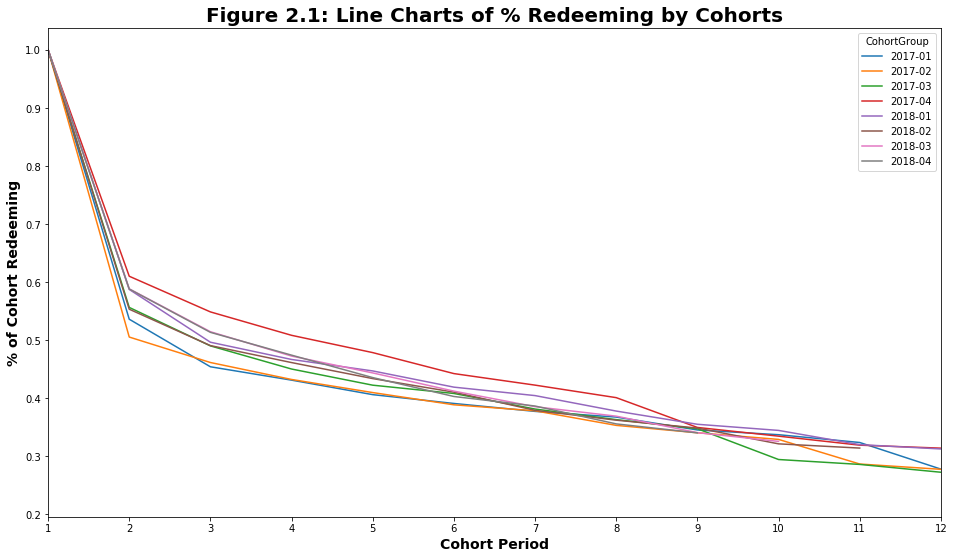

In [21]:
user_retention[['2017-01', '2017-02', '2017-03', '2017-04', 
                '2018-01','2018-02', '2018-03','2018-04']].plot(figsize=(16,9))
plt.title('Figure 2.1: Line Charts of % Redeeming by Cohorts', fontsize=20, fontweight='bold')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Redeeming', fontsize=14, fontweight='bold')
plt.xlabel('Cohort Period', fontsize=14, fontweight='bold');

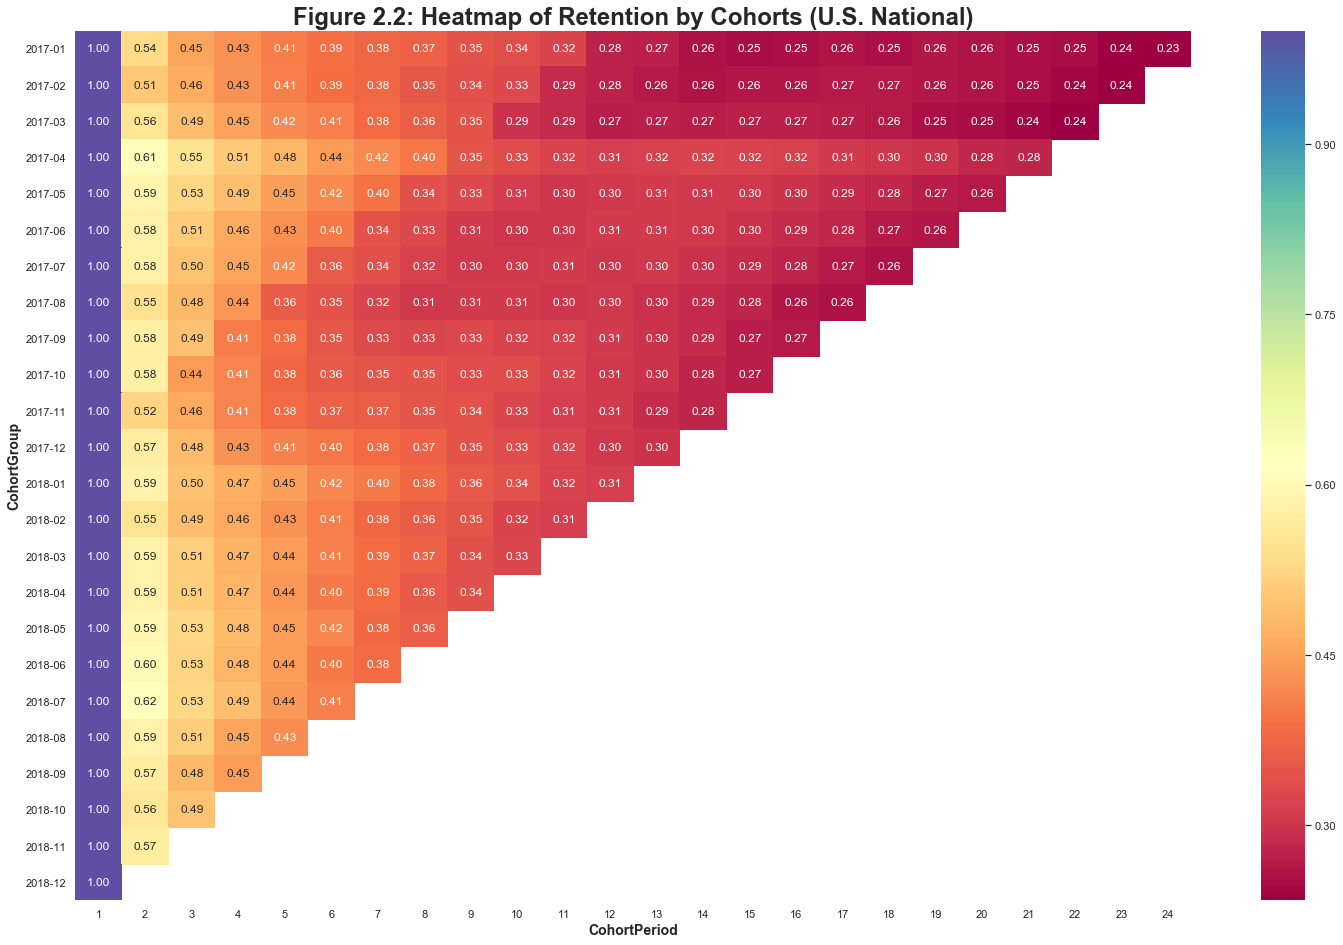

In [24]:
import seaborn as sns
sns.set(style='white')

plt.figure(figsize=(25, 16))
plt.title('Figure 2.2: Heatmap of Retention by Cohorts (U.S. National)', fontsize=24, fontweight='bold')
plt.ylabel("Cohort Group", fontsize=14, fontweight='bold')
plt.xlabel("Cohort Period", fontsize=14, fontweight='bold')
    
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt=".2f", cmap="Spectral", vmin = 0.2, vmax = 1);

Unsurprisingly, we can see from the above chart that fewer MC users tend to redeem as time goes on.

However, we can also see that the **2017-04 cohort** is the strongest, which enables us to ask targeted questions about this cohort compared to others -- what other attributes (besides month of first redemption) do these users share which might be causing them to stick around? How were the majority of these users acquired? Was there a specific marketing campaign that brought them in? 

### 2.2.3 More examples: Heatmaps for MI, CA, TN, CO and U.S. National from 2015-10 to 2018-12

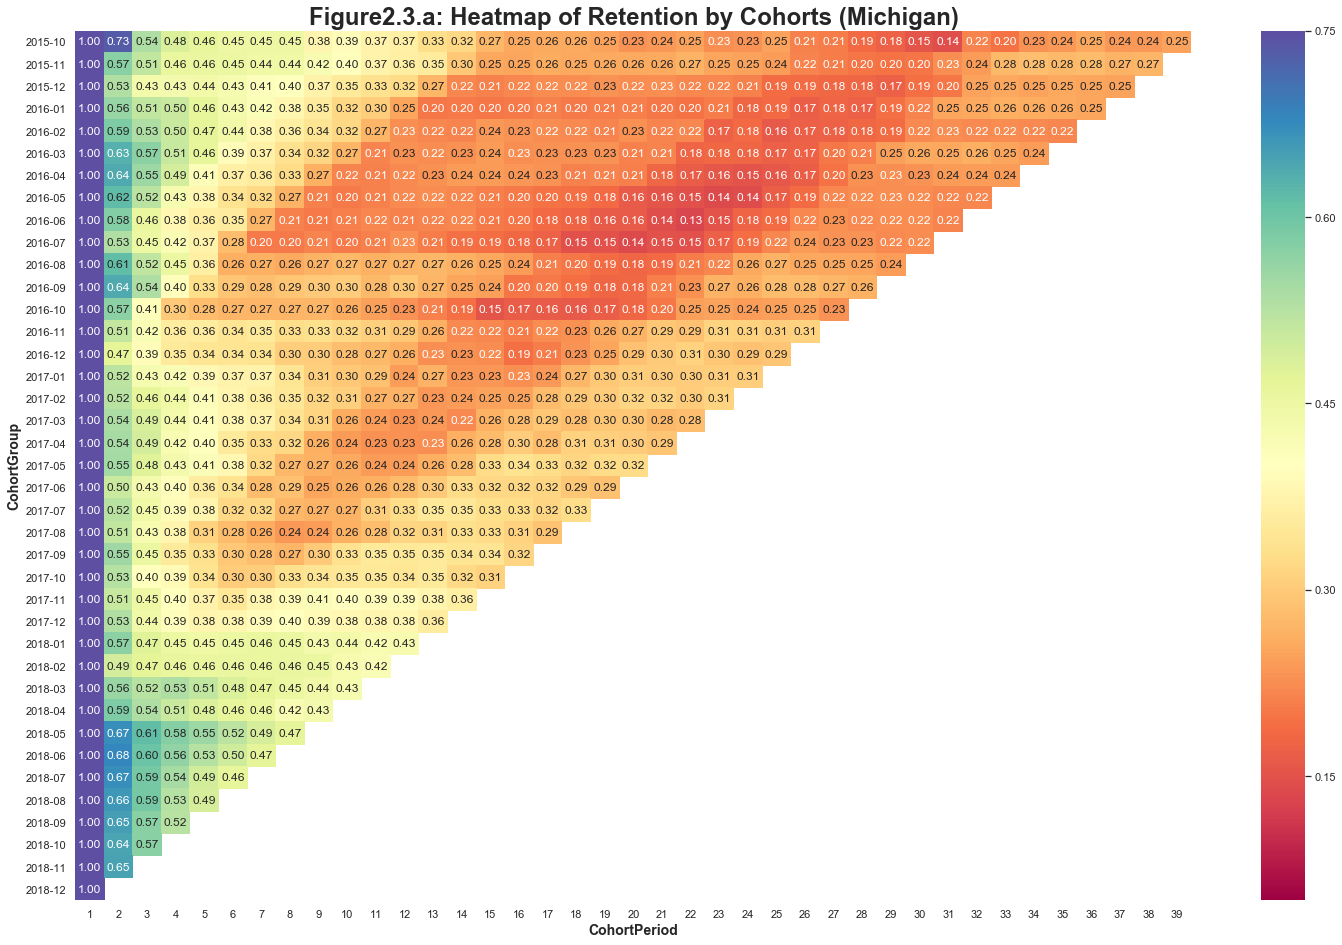

In [121]:
df = pd.read_csv("logs_MI.csv")
heatmap(df, state = "Michigan", figure_label = "2.3.a")

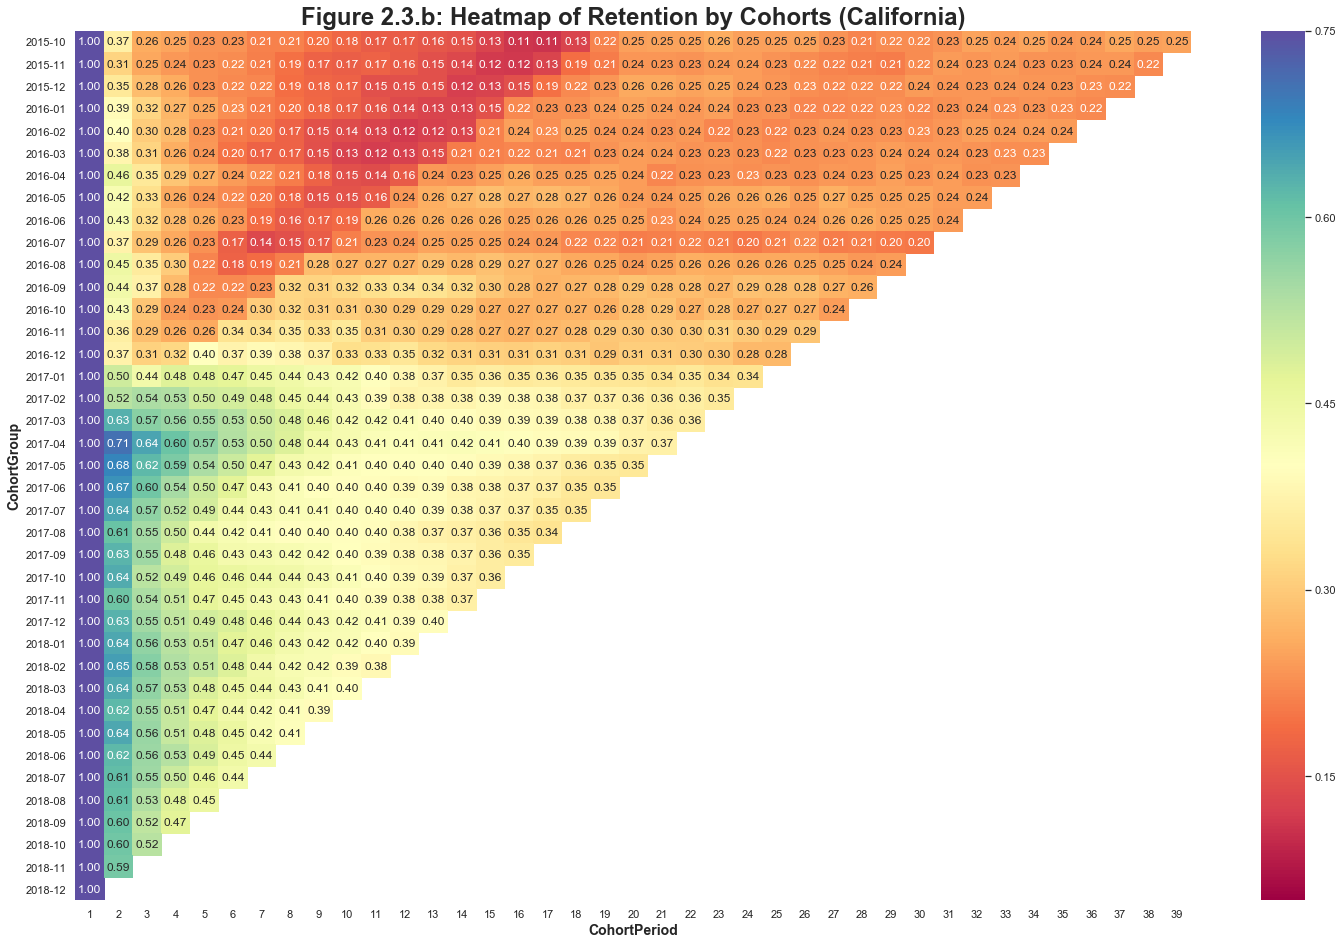

In [70]:
df = pd.read_csv("logs_CA.csv")
heatmap(df, state = "California", figure_label = "2.3.b")

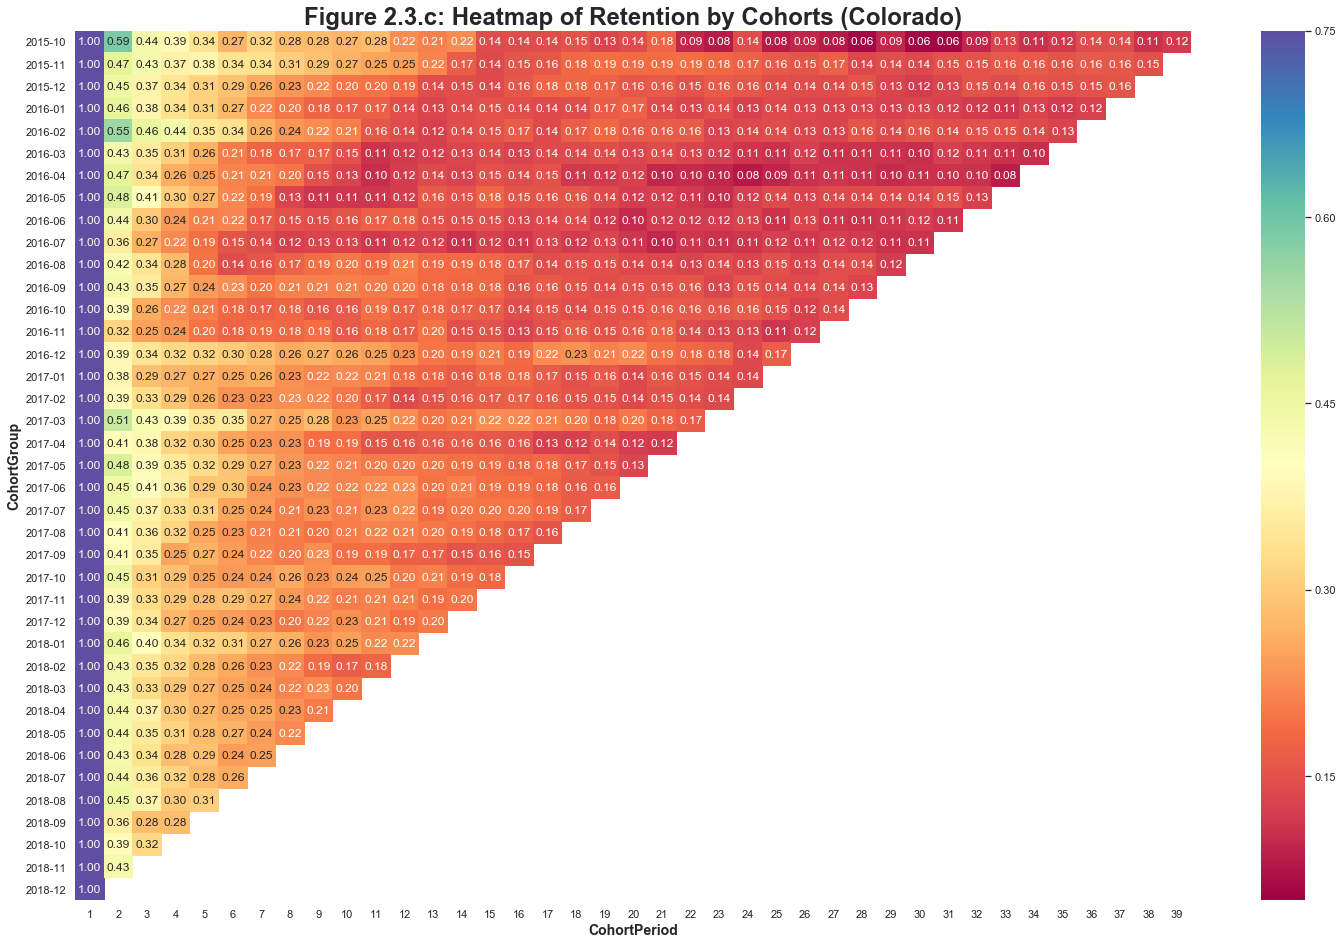

In [72]:
df = pd.read_csv("logs_CA.csv")
heatmap(df, state = "Colorado", figure_label = "2.3.c")

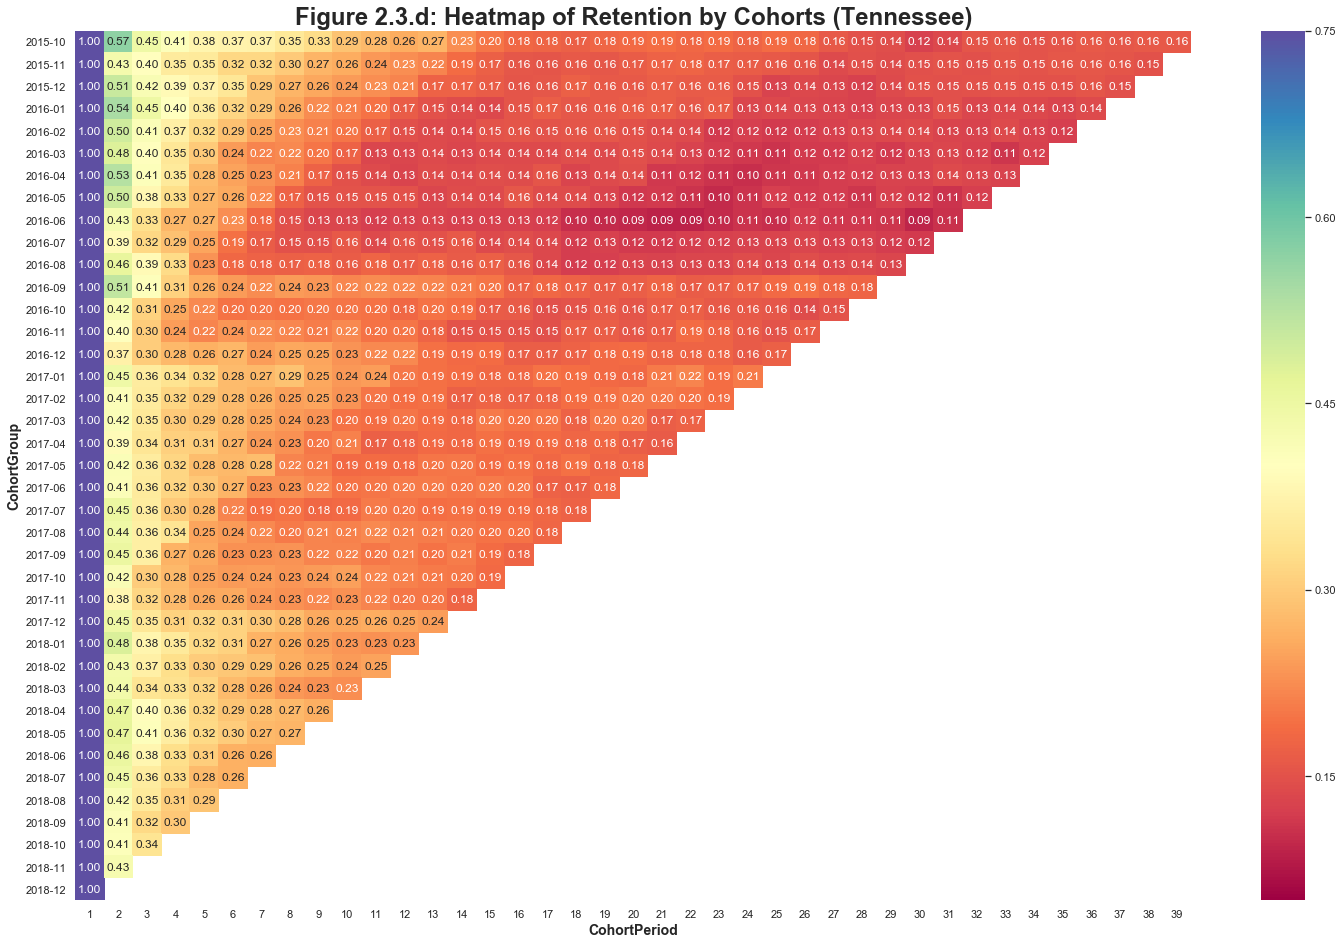

In [74]:
df = pd.read_csv("logs_TN.csv")
heatmap(df, state = "Tennessee", figure_label = "2.3.d")

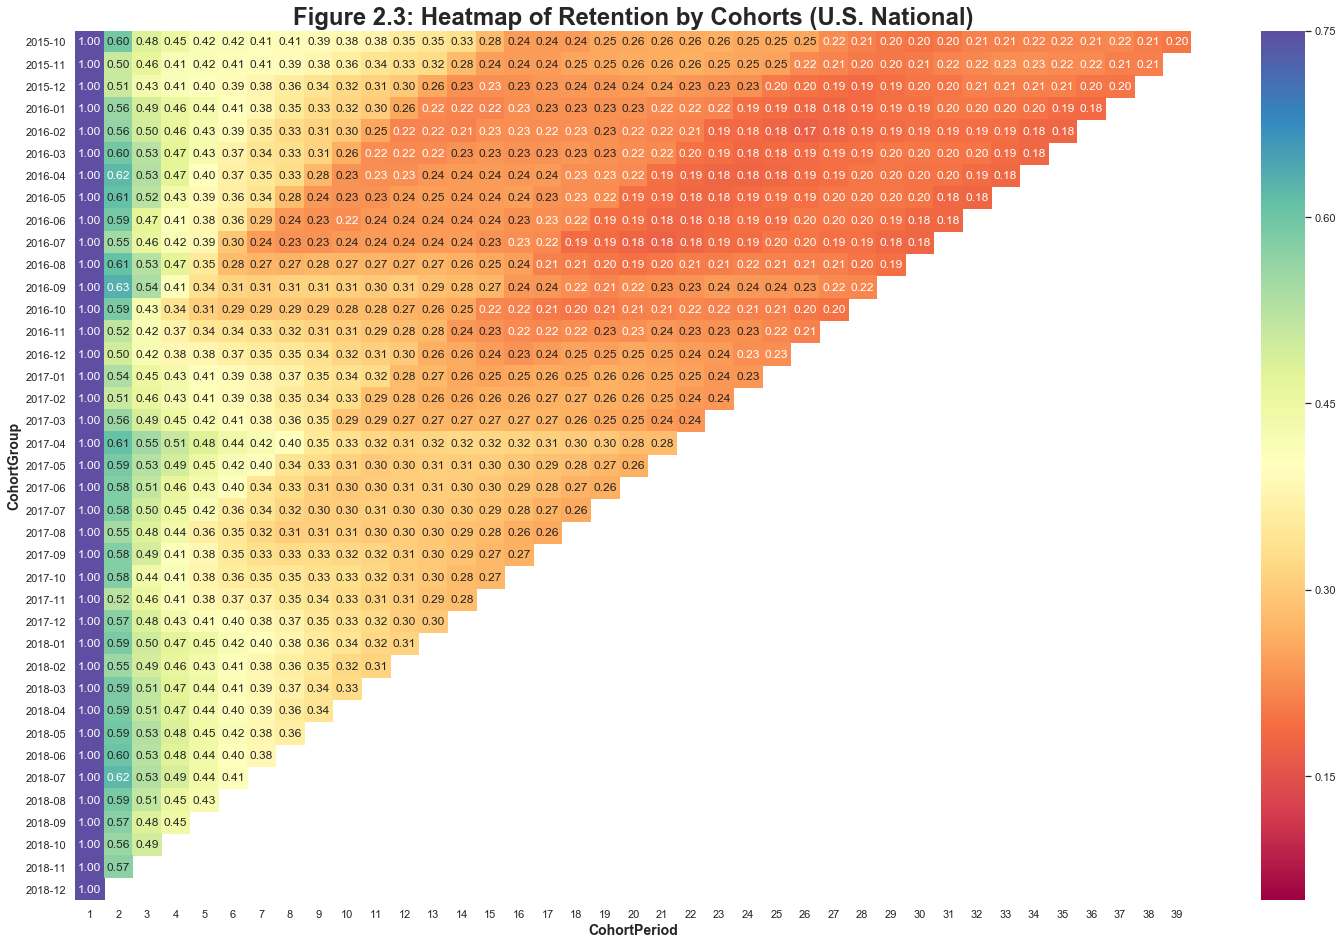

In [77]:
df = pd.read_csv("logs_US.csv") # from 2015-10 to 2018-12)
heatmap(df, state = "U.S. National", figure_label = "2.3.d")

<a id='model-implementation'></a>
# Section III. Implementation with `Lifetimes` 

**Section III** explains the model implementation step-by-step, and shows some preliminary results on individual consumers. 

## 3.1. Parameter Estimation: Modeling All Cohorts

### 3.1.1. Visualizing our Frequency/Recency Matrix

We first run the BG/NBD model on transformed dataset in aggregated form, obtained in **2.1**. The four optimized parameters are given as follows:

In [52]:
# Load data (in aggregated form):
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 1048223 subjects, a: 0.60, alpha: 12.00, b: 10.39, r: 0.57>


Consider a consumer redeemed every day for three weeks straight, and later stopped redeeming in the following months. Then this consumer will most likely to become inactive. On the other hand, a consumer who historically redeemd once a quarter, and still redeemed last quarter as well, is likely to remain alive. We can visualize this relationship using the **Frequency/Recency matrix**, which computes the *expected number of redemption for an consumer to make in the next time period*, given the recency (age at last redemption) and frequency (number of repeat redemption).

From the heatmap we can see that if a consumer has redeemed 300-400 times, and their latest redemption was when they were 120 weeks old, then they are the consumers who are most likelyt to redeem (bottom-right). The consumers who are least likely to redeem are those that are in the top-right corner: they redeemed quickly and then disappear in weeks. 

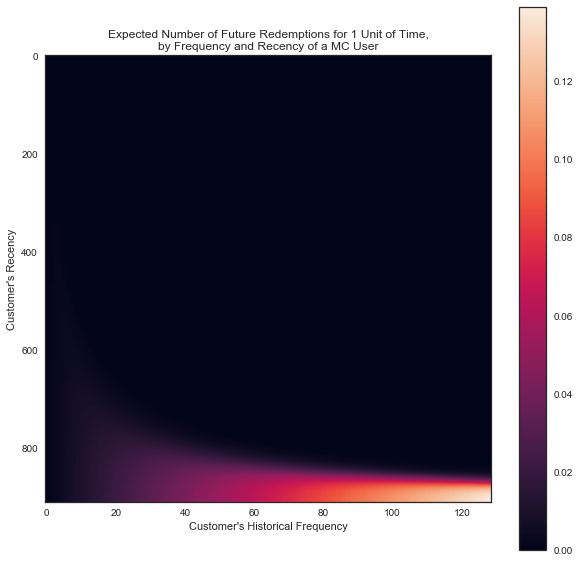

In [115]:
plt.figure(figsize=(10,10))
plot_frequency_recency(bgf);

### 3.1.2 Assessing model fit

The most straightforward way of assessing model fit is to graphically compare model predicted data versus actual data. We can see that our actual data and our simulated data line up well. This shows that our model has decent fit. 

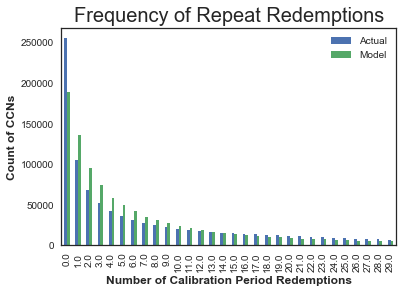

In [132]:
# fit the model:
bgf_cal = BetaGeoFitter(penalizer_coef=0.0)
bgf_cal.fit(summary['frequency'], summary['recency'], summary['T'])

# plot the comparison for model fitting:
plot_period_redemptions(bgf_cal, max_frequency=30, title='Frequency of Repeat Redemptions',
                                 xlabel='Number of Calibration Period Redemptions',
                                 ylabel='Count of CCNs');

<a id='predictive-results'></a>

## 3.2. Predictive Results for All Cohorts

### 3.2.1. Consumer level Predictions

Based on consumer history, we can predict what future redemptions might look like for each individual:

In [13]:
summary_cal_holdout.sort_values('frequency_holdout', ascending=False).head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
ccn,,,,,
483751129,24.0,434.0,440.0,5.0,29
488587623,30.0,224.0,237.0,5.0,29
488587743,29.0,217.0,223.0,5.0,29
488587753,4.0,196.0,216.0,5.0,29
488587784,31.0,224.0,230.0,5.0,29


In [20]:
summary_cal_holdout.loc[483751129]

frequency_cal         24.0
recency_cal          434.0
T_cal                440.0
frequency_holdout      5.0
duration_holdout      29.0
Name: 483751129, dtype: float64

In [30]:
t = 35  # predict redemptions in 35 days (5 weeks)
individual = summary.loc[425088]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

4.786348587209822

In [29]:
summary.sort_values("frequency", ascending=False).head(10)

,ccn,frequency,recency,T
425088,486174385,128.0,903.0,909.0
2099,20454151,128.0,903.0,909.0
914414,543823122,128.0,903.0,909.0
34579,86208853,127.0,896.0,902.0
825246,501716733,127.0,903.0,909.0
967896,668487566,127.0,903.0,909.0
432893,486220310,127.0,889.0,895.0
853610,506373915,127.0,896.0,902.0
36952,89205053,127.0,896.0,902.0
52780,104126767,127.0,896.0,902.0


With the dataset with holdout period, we can perform fitting on the `_cal` columns, and test on the `_holdout` columns:

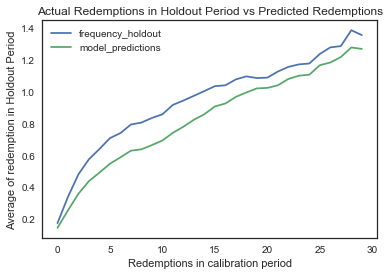

In [107]:
# fit the model:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

# plot the graph (out-of-sample prediction accuracy):
plt.figure(figsize=(20,16))
plot_calibration_redemptions_vs_holdout_redemptions(bgf, summary_cal_holdout, n=30, title="Actual Redemptions in Holdout vs Actual");

In [124]:
df = pd.read_csv("logs_US.csv") 
# aggregated summary form without holdout: 
summary = summary_data_from_transaction_data(df_cohort_ca, 'ccn', 'date', observation_period_end='2018-12-31')
summary_cal_holdout = calibration_and_holdout_data(df_cohort_ca, 'ccn', 'date',
                                        calibration_period_end='2018-10-31',
                                        observation_period_end='2018-12-31')   

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

mape_calibration_redemptions_vs_holdout_redemptions(bgf, summary_cal_holdout)

12.98

### 3.2.2. Consumer Probability Histories

Given a consumer transaction history (e.g. with CCN 483481371), we can calculate their historical probabilities of being active throughout the training period. 

From the graph we can see that when this consumer stops redeeming coupons, the estimated probabilities of being active will keep dropping, until a new redemption occurs. Note that even after a new redemption, estimated probabilities of beling active won't go straight to 1, since the time in data (days) is discrete but the model assumes continuous time input. 

In [35]:
id = 483481371
weeks_since_birth = 10
sp_trans = event_logs.loc[event_logs['ccn'] == id]
sp_trans.head()

,ccn,date,frequency
3814693,483481371,2018-01-07,1
3814694,483481371,2018-01-14,1
3814695,483481371,2018-01-21,1
3814696,483481371,2018-01-28,3
3814697,483481371,2018-02-04,1


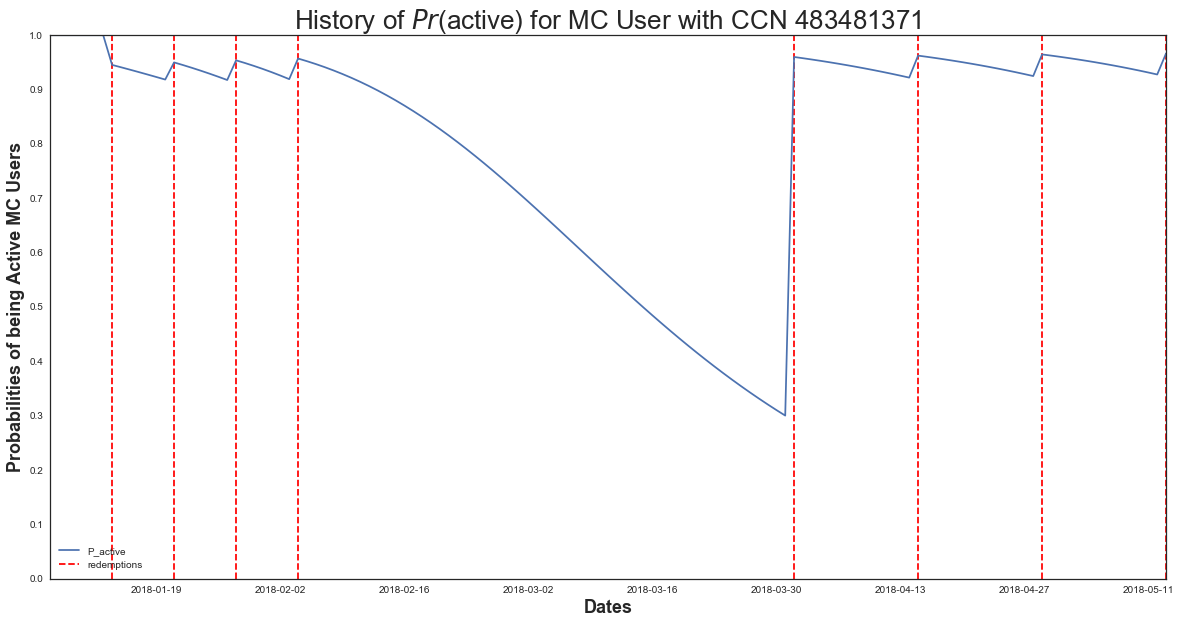

In [130]:
plt.figure(figsize=(12,8))
plot_hist_alive(bgf_cal, weeks_since_birth, sp_trans, 'date');

### 3.2.3. Ranking consumers by expected count of redemptions in the next period

Let's return to all cohorts of consumers and rank them from "highest expected number of redemption in the next period (5 weeks)" to lowest. The `Lifetimes` package includes a method that can predict a consumer's expected number redemptions in the next period using their history:

In [70]:
t = 35 # next 5 weeks
data = summary.copy()
data['predicted_redemptions'] = bgf_cal.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_redemptions').tail(10)

,ccn,frequency,recency,T,predicted_redemptions
442436,486277709,124.0,868.0,874.0,4.817018
12792,55560166,124.0,868.0,874.0,4.817018
34064,85761147,124.0,868.0,874.0,4.817018
437769,486249669,125.0,875.0,881.0,4.818371
901869,527273779,125.0,875.0,881.0,4.818371
124060,151938454,126.0,882.0,888.0,4.819704
122274,151856206,126.0,882.0,888.0,4.819704
78595,119766699,126.0,882.0,888.0,4.819704
435584,486236348,126.0,882.0,888.0,4.819704
432893,486220310,127.0,889.0,895.0,4.821017


<a id='predictive-results-corhort'></a>

## 3.3. Predictive Results for Selected Cohort: April 2017 in California

### 3.3.1. Parameter estimation and goodness of fit

The calibration period is from April 2017 to October 2018 (18 months), and the holdout period is November 2018 to December 2018 (2 months). After repeating the data preprocessing steps described before, we can obtain the four model parameters from the BG/NBD model (on the cohort of April 2017 cohort in Califronia):

In [136]:
df = pd.read_csv("logs_CA.csv")
df['date'] = pd.to_datetime(df['date'])
df['RedPeriod'] = df.date.apply(lambda x: x.strftime('%Y-%m'))

# Determine the user's cohort group (based on their first redemption)
df.set_index('ccn', inplace=True)
df['CohortGroup'] = df.groupby(level=0)['date'].min().apply(lambda x: x.strftime('%Y-%m'))
df.reset_index(inplace=True)

# Rollup data by CohortGroup & RedPeriod:
cohorts = df.groupby(['CohortGroup', 'RedPeriod']).agg({'ccn': pd.Series.nunique,
                                                        'frequency': np.sum})

# Subset national data to cohort (April 2017 Cohort Group):
df_cohort_ca = df.iloc[np.where(df['CohortGroup']=="2017-04")].drop(columns=['RedPeriod', 'CohortGroup']) 
df_cohort_ca.set_index("ccn")

# aggregated summary form without holdout: 
summary = summary_data_from_transaction_data(df_cohort_ca, 'ccn', 'date', observation_period_end='2018-12-31')
summary_cal_holdout = calibration_and_holdout_data(df_cohort_ca, 'ccn', 'date',
                                                   calibration_period_end='2018-10-31',
                                                   observation_period_end='2018-12-31')   

# fit the model:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 3448 subjects, a: 0.29, alpha: 5.64, b: 5.58, r: 0.58>


The following two graphs show that the our actual data and our simulated data line up well; our model has decent fit on this cohort. Model MAPE (mean percentage absolute error) is 13.23% on the holdout period. 

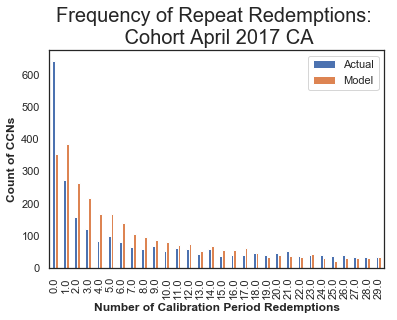

In [137]:
# fit the model:
bgf_cal = BetaGeoFitter(penalizer_coef=0.0)
bgf_cal.fit(summary['frequency'], summary['recency'], summary['T'])

# plot the comparison for model fitting:
plot_period_redemptions(bgf_cal, max_frequency=30, title='Frequency of Repeat Redemptions: \n Cohort April 2017 CA',
                                 xlabel='Number of Calibration Period Redemptions',
                                 ylabel='Count of CCNs');

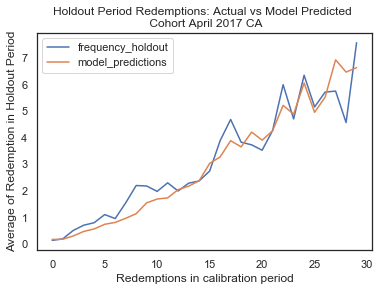

In [138]:
# fit the model:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

# plot the graph (out-of-sample prediction accuracy):
plot_calibration_redemptions_vs_holdout_redemptions(bgf, summary_cal_holdout, n=30, title="Holdout Period Redemptions: Actual vs Model Predicted \n Cohort April 2017 CA");

#### Model MAPE (mean percentage absolute error) is 13.23%:

In [139]:
mape_calibration_redemptions_vs_holdout_redemptions(bgf, summary_cal_holdout)

13.23

Further diagnostics: Threshold classify death as prob <0.05

Holout period: FP & TP

Plot ROC curves

### 3.2.2. Individual Level Estimates

Given a consumer transaction history (e.g. with CCN 488978044), we can calculate their historical probabilities of being active throughout the training period. From the graph we can see that when this consumer stops redeeming coupons, the estimated probabilities of being active will keep dropping, until a new redemption occurs. Note that even after a new redemption, estimated probabilities of beling active won't go straight to 1, since the time in data (days) is discrete but the model assumes continuous time input. 

In [99]:
id = 488978044
weeks_since_birth = 10
sp_trans = df_cohort_ca.loc[df_cohort_ca['ccn'] == id]
sp_trans.head()

,ccn,date,frequency
2634688,488978044,2018-04-06,1
2634689,488978044,2018-04-08,1
2634690,488978044,2018-04-09,1
2634691,488978044,2018-04-11,1
2634692,488978044,2018-04-15,1


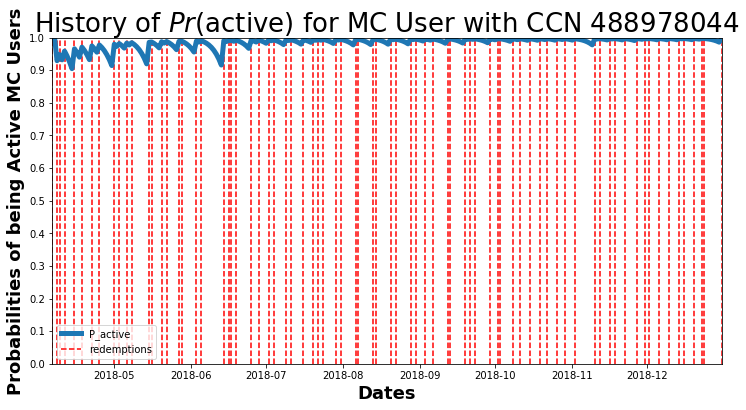

In [101]:
plt.figure(figsize=(12,6))
plot_hist_alive(bgf_cal, weeks_since_birth, sp_trans, 'date');

### 3.3.3. Ranking consumers for cohort: April 2017 CA

Now let's rank these MC users (from the cohort April 2017 in California) from "highest expected number of redemption in the next period (5 weeks)" to lowest:

In [78]:
t = 35 # next 5 weeks
data = summary.copy()
data['predicted_redemptions'] = bgf_cal.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_redemptions').tail(10).round(2)

,frequency,recency,T,predicted_redemptions
ccn,,,,
309165881,76.0,267.0,268.0,9.65
489035518,73.0,256.0,256.0,9.69
488978044,77.0,269.0,269.0,9.74
489040501,73.0,253.0,254.0,9.76
489058221,71.0,247.0,247.0,9.76
484590054,72.0,250.0,250.0,9.78
97575742,74.0,257.0,257.0,9.79
488983069,78.0,269.0,269.0,9.87
489024536,75.0,257.0,257.0,9.92


### 3.3.4. Forecast of redemption for selected cohort: April 2017 CA

Finally, we can project the frequency of redemption (aggregated to weekly level) to future periods. The green line shows the end of calibration period (2018/12/31). We make the six month forecast based on the model:

In [343]:
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.utils import calibration_and_holdout_data
from lifetimes import BetaGeoFitter

df = pd.read_csv("logs_CA.csv")
df['date'] = pd.to_datetime(df['date'])
df['RedPeriod'] = df.date.apply(lambda x: x.strftime('%Y-%m'))

# Determine the user's cohort group (based on their first redemption)
df.set_index('ccn', inplace=True)
df['CohortGroup'] = df.groupby(level=0)['date'].min().apply(lambda x: x.strftime('%Y-%m'))
df.reset_index(inplace=True)

# Rollup data by CohortGroup & RedPeriod:
cohorts = df.groupby(['CohortGroup', 'RedPeriod']).agg({'ccn': pd.Series.nunique,
                                                        'frequency': np.sum})

# Subset national data to cohort (April 2017 Cohort Group):
df_cohort_ca = df.iloc[np.where(df['CohortGroup']=="2017-04")].drop(columns=['RedPeriod', 'CohortGroup']) 
df_cohort_ca.set_index("ccn")

# aggregated summary form without holdout: 
summary = summary_data_from_transaction_data(df_cohort_ca, 'ccn', 'date', observation_period_end='2018-12-31')
summary_cal_holdout = calibration_and_holdout_data(df_cohort_ca, 'ccn', 'date',
                                        calibration_period_end='2018-10-31',
                                        observation_period_end='2018-12-31')   

# fit the model:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 13547 subjects, a: 0.31, alpha: 5.29, b: 10.04, r: 0.64>

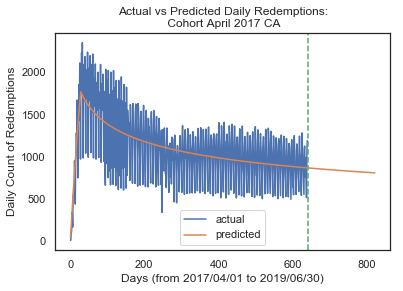

In [377]:
import datetime

# set dates:
start_date = datetime.date(2017, 3, 31)
end_date = datetime.date(2019, 7, 1)
cal_date = datetime.date(2018, 12, 31)
T = (end_date - start_date).days
t_cal = (cal_date - start_date).days

df = expected_cumulative_redemptions(bgf, df_cohort_ca, 'date', 'ccn', T)
# recover incremendal changes from cumsum
df['predicted'] -= df['predicted'].shift(1).fillna(0) 
df['actual'] -= df['actual'].shift(1).fillna(0) 
df[df==0 ] = np.nan # remove 0s (empty actual values)
df = df.iloc[1:]

# plot:
plt = df.plot(title = 'Actual vs Predicted Daily Redemptions:\n Cohort April 2017 CA');
plt.axvline(x=t_cal, color='g', linestyle='--');
plt.set_xlabel('Days (from 2017/04/01 to 2019/06/30)');
plt.set_ylabel("Daily Count of Redemptions");

Aggregated to weekly level:

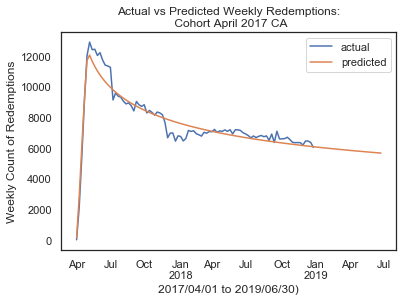

In [378]:
df['date'] = pd.date_range(datetime.date(2017, 4, 1), datetime.date(2019, 6, 30))
df.set_index('date', inplace = True)
df = df.resample('W').agg('sum')
df[df==0 ] = np.nan # remove 0s (empty actual values)
# df.reset_index(level=0)
plt = df.plot(title = 'Actual vs Predicted Weekly Redemptions:\n Cohort April 2017 CA');
plt.set_xlabel('2017/04/01 to 2019/06/30)');
plt.set_ylabel("Weekly Count of Redemptions");

### Compared to the model on all cohorts, we saw lower MAPE and better fit. 

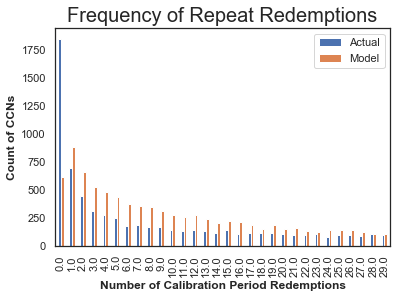

In [379]:
df = pd.read_csv("logs_US.csv") 
# aggregated summary form without holdout: 
summary = summary_data_from_transaction_data(df_cohort_ca, 'ccn', 'date', observation_period_end='2018-12-31')
summary_cal_holdout = calibration_and_holdout_data(df_cohort_ca, 'ccn', 'date',
                                        calibration_period_end='2018-10-31',
                                        observation_period_end='2018-12-31')   

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
# plot the comparison for model fitting:
plot_period_redemptions(bgf, max_frequency=30, title='Frequency of Repeat Redemptions',
                             xlabel='Number of Calibration Period Redemptions',
                             ylabel='Count of CCNs');

<a id="further-reading"></a>
## Further Reading

Probabilistic models are popular in the consumer lifetime value literature. The following are a list of papers for further reading:

* [Counting Your Customers The Easy Way, Peter S. Fader and Bruce Hardie](http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf)

* [Counting Your Customers One By One, A Hierarchical Bayes Extension to the Pareto/NBD Model, Peter S. Fader and Jen Shang](http://www.brucehardie.com/papers/020/)


Bayesian Analysis Textbooks:

* Doing Bayesian Data Analysis, John Kruschke
* Statistical Rethinking, Richard McElreath
* Bayesian Data Analysis, Andrew Gelman

Below are functions used to created graphs in the report:

In [157]:
def plot_period_redemptions(model, max_frequency, title, xlabel, ylabel, **kwargs):
    """
    Plot a figure with period actual and predicted transactions.
    """
    from matplotlib import pyplot as plt
    labels = kwargs.pop('label', ['Actual', 'Model'])

    n = model.data.shape[0]
    simulated_data = model.generate_new_data(size=n)

    model_counts = pd.DataFrame(model.data['frequency'].value_counts().sort_index().iloc[:max_frequency])
    simulated_counts = pd.DataFrame(simulated_data['frequency'].value_counts().sort_index().iloc[:max_frequency])
    combined_counts = model_counts.merge(simulated_counts, how='outer', left_index=True, right_index=True).fillna(0)
    combined_counts.columns = labels

    ax = combined_counts.plot(kind='bar', **kwargs);

    plt.legend()
    plt.title(title, size=20)
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12, fontweight='bold')
    
    return ax



def plot_calibration_redemptions_vs_holdout_redemptions(model, calibration_holdout_matrix, title, kind="frequency_cal", n=7, **kwargs):
    """
    Plot calibration redemptions vs holdout.
    """
    from matplotlib import pyplot as plt

    x_labels = {
        "frequency_cal": "Redemptions in calibration period",
        "recency_cal": "Age of customer at last redemption",
        "T_cal": "Age of customer at the end of calibration period",
        "time_since_last_purchase": "Time since user made last redemption"
    }
    summary = calibration_holdout_matrix.copy()
    duration_holdout = summary.iloc[0]['duration_holdout']

    summary['model_predictions'] = summary.apply(lambda r: model.conditional_expected_number_of_purchases_up_to_time(duration_holdout, r['frequency_cal'], r['recency_cal'], r['T_cal']), axis=1)

    if kind == "time_since_last_redemption":
        summary["time_since_last_redemption"] = summary["T_cal"] - summary["recency_cal"]
        ax = summary.groupby(["time_since_last_redemption"])[['frequency_holdout', 'model_predictions']].mean().iloc[:n].plot(**kwargs)
    else:
        ax = summary.groupby(kind)[['frequency_holdout', 'model_predictions']].mean().iloc[:n].plot(**kwargs)

    plt.title(title)
    plt.xlabel(x_labels[kind])
    plt.ylabel('Average of Redemption in Holdout Period')
    plt.legend()
    
    return ax



def plot_hist_alive(model, t, transactions, datetime_col, freq='D', start_date=None, end_date=None, ax=None, Zax=None, **kwargs):
    """
    Draw a graph showing the probablility of being alive for a customer in time.
    """
    from matplotlib import pyplot as plt
    from lifetimes.utils import calculate_alive_path, expected_cumulative_transactions

    if start_date is None:
        start_date = min(transactions[datetime_col])

    if ax is None:
        ax = plt.subplot(111)

    # Get redemption history of user
    customer_history = transactions[[datetime_col]].copy()
    customer_history.index = pd.DatetimeIndex(customer_history[datetime_col])

    # Add redemptions column
    customer_history['redemptions'] = 1
    customer_history = customer_history.resample(freq).sum()

    # plot alive_path
    path = calculate_alive_path(model, transactions, datetime_col, t, freq)
    path_dates = pd.date_range(start=min(transactions[datetime_col]), periods=len(path), freq=freq)
    plt.plot(path_dates, path, '-', label='P_active', linewidth=5)
    
    if end_date is None:
        end_date = path_dates[-1]

    # plot buying dates
    payment_dates = customer_history[customer_history['redemptions'] >= 1].index
    plt.vlines(payment_dates.values, ymin=0, ymax=1, colors='r', linestyles='dashed', label='redemptions')

    plt.ylim(0, 1.0)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlim(start_date, end_date)
    plt.legend(loc=3)
    plt.ylabel('Probabilities of being Active MC Users', fontsize=18, fontweight='bold')
    plt.xlabel('Dates', fontsize=18, fontweight='bold')
    plt.title('History of $\it{Pr}$(active) for MC User with CCN ' + str(id), size=26)

    return ax



def _find_first_transactions(transactions, customer_id_col, datetime_col, monetary_value_col=None, datetime_format=None,
                             observation_period_end=None, freq='D'):
    """
    Return dataframe with first transactions.
    This takes a Dataframe of transaction data of the form:
        customer_id, datetime [, monetary_value]
    and appends a column named 'repeated' to the transaction log which indicates which rows
    are repeated transactions for that customer_id.
    """
    if observation_period_end is None:
        observation_period_end = transactions[datetime_col].max()

    if isinstance(observation_period_end, pd.Period):
        observation_period_end = observation_period_end.to_timestamp()

    select_columns = [customer_id_col, datetime_col]

    if monetary_value_col:
        select_columns.append(monetary_value_col)

    transactions = transactions[select_columns].sort_values(select_columns).copy()

    # make sure the date column uses datetime objects, and use Pandas' DateTimeIndex.to_period()
    # to convert the column to a PeriodIndex which is useful for time-wise grouping and truncating
    transactions[datetime_col] = pd.to_datetime(transactions[datetime_col], format=datetime_format)
    transactions = transactions.set_index(datetime_col).to_period(freq).to_timestamp()

    transactions = transactions.loc[(transactions.index <= observation_period_end)].reset_index()

    period_groupby = transactions.groupby([datetime_col, customer_id_col], sort=False, as_index=False)

    if monetary_value_col:
        # when we have a monetary column, make sure to sum together any values in the same period
        period_transactions = period_groupby.sum()
    else:
        # by calling head() on the groupby object, the datetime_col and customer_id_col columns
        # will be reduced
        period_transactions = period_groupby.head(1)

    # initialize a new column where we will indicate which are the first transactions
    period_transactions['first'] = False
    # find all of the initial transactions and store as an index
    first_transactions = period_transactions.groupby(customer_id_col, sort=True, as_index=False).head(1).index
    # mark the initial transactions as True
    period_transactions.loc[first_transactions, 'first'] = True
    select_columns.append('first')
    # reset datetime_col to period
    period_transactions[datetime_col] = pd.Index(period_transactions[datetime_col]).to_period(freq)

    return period_transactions[select_columns]



def expected_cumulative_redemptions(model, transactions, datetime_col,
                                     customer_id_col, t, datetime_format=None,
                                     freq='D', set_index_date=False,
                                     freq_multiplier=1):
    """
    Get expected and actual repeated cumulative transactions.
    """
    start_date = pd.to_datetime(transactions[datetime_col],
                                format=datetime_format).min()
    start_period = start_date.to_period(freq)
    observation_period_end = start_period + t

    repeated_and_first_transactions = _find_first_transactions(
        transactions,
        customer_id_col,
        datetime_col,
        datetime_format=datetime_format,
        observation_period_end=observation_period_end,
        freq=freq
    )

    first_trans_mask = repeated_and_first_transactions['first']
    repeated_transactions = repeated_and_first_transactions[~first_trans_mask]
    first_transactions = repeated_and_first_transactions[first_trans_mask]

    date_range = pd.date_range(start_date, periods=t + 1, freq=freq)
    date_periods = date_range.to_period(freq)

    pred_cum_transactions = []
    first_trans_size = first_transactions.groupby('redemptiondate').size()
    for i, period in enumerate(date_periods):
        if i % freq_multiplier == 0 and i > 0:
            times = period - first_trans_size.index
            times = times[times > 0].astype(float) / freq_multiplier
            expected_trans_agg = \
                model.expected_number_of_purchases_up_to_time(times)

            mask = first_trans_size.index < period
            expected_trans = sum(expected_trans_agg * first_trans_size[mask])
            pred_cum_transactions.append(expected_trans)

    act_trans = repeated_transactions.groupby('redemptiondate').size()
    act_tracking_transactions = act_trans.reindex(date_periods, fill_value=0)

    act_cum_transactions = []
    for j in range(1, t // freq_multiplier + 1):
        sum_trans = sum(act_tracking_transactions.iloc[:j * freq_multiplier])
        act_cum_transactions.append(sum_trans)

    if set_index_date:
        index = date_periods[freq_multiplier - 1: -1:freq_multiplier]
    else:
        index = range(0, t // freq_multiplier)

    df_cum_transactions = pd.DataFrame({'actual': act_cum_transactions,
                                        'predicted': pred_cum_transactions},
                                       index=index)

    return df_cum_transactions


def plot_cumulative_redemptions(model, transactions, datetime_col, customer_id_col, t, t_cal, title, 
                                 datetime_format=None, freq='D', set_index_date=False,
                                 xlabel='day', ylabel='Cumulative Redemptions', 
                                 ax=None, **kwargs):
    """
    Plot a figure of the predicted and actual cumulative transactions of users.
    """
    from matplotlib import pyplot as plt

    if ax is None:
        ax = plt.subplot(111)

    df_cum_transactions = expected_cumulative_redemptions(model, transactions, datetime_col,
                                                           customer_id_col, t,
                                                           datetime_format=datetime_format, freq=freq,
                                                           set_index_date=set_index_date)

    ax = df_cum_transactions.plot(ax=ax, title=title, **kwargs)

    if set_index_date:
        x_vline = df_cum_transactions.index[int(t_cal)]
        xlabel = 'date'
    else:
        x_vline = t_cal
#         x_vline1 = t_cal[0]
#         x_vline2 = t_cal[1]
#         ax.axvline(x=x_vline1, color='r', linestyle='--')
#         ax.axvline(x=x_vline2, color='g', linestyle='--')
    
    ax.axvline(x=x_vline, color='g', linestyle='--')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # ax.ylim(ylim)
    
    return ax


def plot_incremental_redemptions(model, transactions, datetime_col, customer_id_col, t, t_cal, title,
                                 datetime_format=None, freq='D', set_index_date=False,
                                 xlabel='day', ylabel='Redemptions',
                                 ax=None, **kwargs):
    """
    Plot a figure of the predicted and actual cumulative transactions of users.
    """
    from matplotlib import pyplot as plt

    if ax is None:
        ax = plt.subplot(111)

    df_cum_transactions = expected_cumulative_redemptions(model, transactions, datetime_col,
                                                           customer_id_col, t,
                                                           datetime_format=datetime_format, freq=freq,
                                                           set_index_date=set_index_date)

    # get incremental from cumulative transactions
    df_cum_transactions = df_cum_transactions.apply(lambda x: x - x.shift(1))
    ax = df_cum_transactions.plot(ax=ax, title=title, **kwargs)

    if set_index_date:
        x_vline = df_cum_transactions.index[int(t_cal)]
        xlabel = 'redemptiondate'
        ax.axvline(x=x_vline, color='r', linestyle='--')
    else:
        x_vline = t_cal
#         x_vline1 = t_cal[0]
#         x_vline2 = t_cal[1]
#         ax.axvline(x=x_vline1, color='r', linestyle='--')
#         ax.axvline(x=x_vline2, color='g', linestyle='--')

    ax.axvline(x=x_vline, color='r', linestyle='--')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax



def heatmap(data, state, figure_label):
    """
    Create heatmap of MC user retention given data and labels (state name and figure title)
    """
    
    # 1. Create a Redemption Period column based on date of redemption:
    df = data
    df['date'] = pd.to_datetime(df['date'])
    df['RedPeriod'] = df.date.apply(lambda x: x.strftime('%Y-%m'))

    # 2. Determine the user's cohort group (based on their first redemption)
    df.set_index('ccn', inplace=True)
    df['CohortGroup'] = df.groupby(level=0)['date'].min().apply(lambda x: x.strftime('%Y-%m'))
    df.reset_index(inplace=True)

    # 3. Rollup data by CohortGroup & RedPeriod:
    cohorts = df.groupby(['CohortGroup', 'RedPeriod']).agg({'ccn': pd.Series.nunique,
                                                            'frequency': np.sum})
    cohorts.rename(columns={'ccn': 'TotalUsers',
                            'frequency': 'TotalRedemptions'}, inplace=True)

    # 4. Label the CohortPeriod for each CohortGroup
    cohorts = cohorts.groupby(level=0).apply(cohort_period)
    
    # 5. Reindex the DataFrame
    cohorts.reset_index(inplace=True)
    cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

    # 6. Create a Series holding the total size of each CohortGroup
    cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
    
    # 7. Calculate user retention
    user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
    
    import seaborn as sns
    sns.set(style='white')

    plt.figure(figsize=(25, 16))
    plt.title('Figure' + figure_label + ': Heatmap of Retention by Cohorts (' + state + ')', fontsize=24, fontweight='bold')
    plt.ylabel("Cohort Group", fontsize=14, fontweight='bold')
    plt.xlabel("Cohort Period", fontsize=14, fontweight='bold')

    sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt=".2f", cmap="Spectral", vmin = 0.05, vmax = 0.75);
    
    
#-----------------------------------------------------------------------------------------------------------------

#### Utility Functions: ####

def cohort_period(df):
    """
    Creates a `CohortPeriod` column, i.e. the Nth period based on the user's first redemption.
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df


def mean_absolute_percentage_error(y_true, y_pred): 
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

def mape_calibration_redemptions_vs_holdout_redemptions(model, calibration_holdout_matrix, kind="frequency_cal"):
    """
    MAPE for calibration redemptions actual vs model during holdout.
    """
    logs = calibration_redemptions_vs_holdout_redemptions(model, calibration_holdout_matrix, kind)
    mape = mean_absolute_percentage_error(logs['frequency_holdout'], logs['model_predictions'])
    
    return mape

def calibration_redemptions_vs_holdout_redemptions(model, calibration_holdout_matrix, kind="frequency_cal"):
    """
    calibration redemptions actual vs model during holdout.
    """
    summary = calibration_holdout_matrix.copy()
    duration_holdout = summary.iloc[0]['duration_holdout']
    summary['model_predictions'] = summary.apply(lambda r: 
                                                 model.conditional_expected_number_of_purchases_up_to_time(duration_holdout, r['frequency_cal'], r['recency_cal'], r['T_cal']), axis=1)

    logs = summary.groupby(kind)[['frequency_holdout', 'model_predictions']].mean()
    
    return logs